<a href="https://colab.research.google.com/github/zeerafle/banana-leaf-desease-classification/blob/main/Banana_Leaf_Desease_Classification_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Extraction

## Setup Environment

In [1]:
!pip install mahotas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.7 MB 6.3 MB/s 


In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py

In [17]:
TRAIN_PATH = 'dataset/train'
TEST_PATH = 'dataset/test'
VAL_PATH = 'dataset/val'
FIXED_SIZE = (500, 500)
BINS = 8

# ubah ke 'output/train_data.h5'
H5_TRAIN_DATA = '/content/drive/MyDrive/banana-leaf/output/train_data.h5'
# ubah ke 'output/train_labels.h5'
H5_TRAIN_LABELS = '/content/drive/MyDrive/banana-leaf/output/train_labels.h5'

## Ambil data

Data langsung didownload dari [kaggle](https://www.kaggle.com/datasets/kaiesalmahmud/banana-leaf-dataset?select=train). Sebelum menjalankan kode dibawah jalankan langkah berikut untuk mendapatkan credential kaggle:

1. Buka [kaggle](kaggle.com), login kalo belum login
2. Klik foto profil
3. Pilih `account`
4. Scroll kebawah sampe ketemu section API
5. Klik `Create New API token`, nanti bakal download `kaggle.json`
6. Simpan di mana aja
7. Upload kaggle.json ke google drive lu, jangan simpan di dalam folder, simpan aja di paling luar.
8. Done, enjoy, salam luar biasa.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%%bash
pip install kaggle
mkdir ~/.kaggle
cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
chmod 600 ~/.kaggle/kaggle.json
kaggle datasets download -d kaiesalmahmud/banana-leaf-dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



100%|██████████| 3.29G/3.29G [00:37<00:00, 93.9MB/s]


In [6]:
%%bash
mkdir dataset
unzip \*.zip -d dataset && rm *.zip

Archive:  banana-leaf-dataset.zip
  inflating: dataset/test/cordana/1615455263756.jpg  
  inflating: dataset/test/cordana/1615455263764.jpg  
  inflating: dataset/test/cordana/1615455263771.jpg  
  inflating: dataset/test/cordana/1615455263787.jpg  
  inflating: dataset/test/cordana/1615455263804.jpg  
  inflating: dataset/test/cordana/1615455263832.jpg  
  inflating: dataset/test/cordana/1615455263850.jpg  
  inflating: dataset/test/cordana/1615455263868.jpg  
  inflating: dataset/test/cordana/1615455263878.jpg  
  inflating: dataset/test/cordana/1615455263914.jpg  
  inflating: dataset/test/cordana/1615455263923.jpg  
  inflating: dataset/test/cordana/1615455263932.jpg  
  inflating: dataset/test/cordana/1615455263940.jpg  
  inflating: dataset/test/cordana/1615455263949.jpg  
  inflating: dataset/test/cordana/1615455263959.jpg  
  inflating: dataset/test/cordana/1615455263976.jpg  
  inflating: dataset/test/cordana/1615455264032.jpg  
  inflating: dataset/test/cordana/1615455264041.

In [7]:
!mkdir --parents --verbose /content/drive/MyDrive/banana-leaf/output

## Preprocess

The feature descriptor describes an interest point and encodes the description in the form of a multidimensional feature vector in the vector space.

In [8]:
# convert setiap gambar dari rgb ke bgr
def rgb_bgr(image):
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return rgb_img

# convert setiap gambar dari rgb ke hsv
def bgr_hsv(rgb_img):
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    return hsv_img

def img_segmentation(rgb_img, hsv_img):
    """Fungsi untuk segmentasi
    Untuk ekstraksi warna hijau dan coklat"""
    lower_green = np.array([25,0,20])
    upper_green = np.array([100,255,255])
    healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)
    result = cv2.bitwise_and(rgb_img,rgb_img, mask=healthy_mask)
    lower_brown = np.array([10,0,10])
    upper_brown = np.array([30,255,255])
    disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
    disease_result = cv2.bitwise_and(rgb_img, rgb_img, mask=disease_mask)
    final_mask = healthy_mask + disease_mask
    final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)
    return final_result

# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [BINS, BINS, BINS], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

## Input Preparation

In [9]:
# dapatkan label training
train_labels = os.listdir(TRAIN_PATH)

# urutkan training label
train_labels.sort()
print(train_labels)

# variabel penampung vektor fitur dan label
global_features = []
labels = []

['cordana', 'healthy', 'pestalotiopsis', 'sigatoka']


In [10]:
# loop sub-folder pada training data
for training_name in train_labels:
    # join path training data dan setiap sub-folder nya
    dir = os.path.join(TRAIN_PATH, training_name)

    # dapatkan training label
    current_label = training_name

    # loop gambar di setiap sub-folder
    for image_name in os.listdir(dir):
        # dapatkan path ke file image
        file_name = os.path.join(dir, image_name)

        # baca image dan resize ke fixed-size
        image = cv2.imread(file_name)
        image = cv2.resize(image, FIXED_SIZE)

        # jalankan fungsi preprocessing satu per satu
        bgr_image = rgb_bgr(image)
        hsv_image = bgr_hsv(bgr_image)
        segmented_img = img_segmentation(bgr_image,hsv_image)

        # jalankan fungsi feature descriptor
        fv_hu_moments = fd_hu_moments(segmented_img)
        fv_haralick = fd_haralick(segmented_img)
        fv_histogram = fd_histogram(segmented_img)
        
        # gabungin
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
        
        # tambahkan ke dalam variabel penampung yang sudah dibuat
        labels.append(current_label)
        global_features.append(global_feature)

    print(f"Memroses folder: {current_label}")

print("Selesai global feature extraction")

Memroses folder: cordana
Memroses folder: healthy
Memroses folder: pestalotiopsis
Memroses folder: sigatoka
Selesai global feature extraction


In [11]:
print(f"Ukuran vektor fitur: {np.array(global_features).shape}")
print(f"Ukuran training label: {np.array(labels).shape}")

Ukuran vektor fitur: (777, 532)
Ukuran training label: (777,)


In [12]:
# encode target labels
target_names = np.unique(labels)
le = LabelEncoder()
target = le.fit_transform(labels)
print("training label encoded")

training label encoded


In [13]:
# ubah skala fitur menjadi (0-1)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("feature vector normalized...")

feature vector normalized...


In [14]:
print(f"Target labels: {target}")
print(f"Target labels shape: {target.shape}")

Target labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3

In [15]:
# simpan vektor feature ke file bentuk hdf5
h5f_data = h5py.File(H5_TRAIN_DATA, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

<HDF5 dataset "dataset_1": shape (777, 532), type "<f8">

In [16]:
# simpan label training ke file bentuk hdf5
h5f_label = h5py.File(H5_TRAIN_LABELS, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

<HDF5 dataset "dataset_1": shape (777,), type "<i8">

In [18]:
h5f_data.close()
h5f_label.close()

# Training

## Setup Environment

In [59]:
import h5py
import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import joblib

warnings.filterwarnings('ignore')

In [20]:
NUM_TREES = 100
TEST_SIZE = 0.20
SEED = 9
TRAIN_PATH = 'dataset/train'
TEST_PATH = 'dataset/test'
VAL_PATH = 'dataset/val'
H5_TRAIN_DATA = '/content/drive/MyDrive/banana-leaf/output/train_data.h5'
H5_TRAIN_LABELS = '/content/drive/MyDrive/banana-leaf/output/train_labels.h5'
SCORING = 'accuracy'

## Data Preparation

In [21]:
# dapatkan training labels
train_labels = os.listdir(TRAIN_PATH)

# sort the training labels
train_labels.sort()

if not os.path.exists(TEST_PATH):
    os.makedirs(TEST_PATH)

## Machine Learning Models

In [ ]:
# models = [
#     ('LR', LogisticRegression(random_state=SEED)),
#     ('LDA', LinearDiscriminantAnalysis()),
#     ('KNN', KNeighborsClassifier()),
#     ('CART', DecisionTreeClassifier(random_state=SEED)),
#     ('RF', RandomForestClassifier(n_estimators=NUM_TREES, random_state=SEED)),
#     ('NB', GaussianNB()),
#     ('SVM', SVC(random_state=SEED))
# ]

In [23]:
# variabel untuk menyimpan hasil dan nama
results = []
names = []

In [24]:
# import fitur vektor dan label yang telah ditrain
h5f_data  = h5py.File(H5_TRAIN_DATA, 'r')
h5f_label = h5py.File(H5_TRAIN_LABELS, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# cek shape fitur vektor dan label
print(f'Features shape: {global_features.shape}')
print(f'Labels shape: {global_labels.shape}')

Features shape: (777, 532)
Labels shape: (777,)


In [25]:
X_train = global_features
y_train = global_labels

## Training Model

In [109]:
# model = KNeighborsClassifier(n_neighbors=9)
# model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [120]:
model = RandomForestClassifier(n_estimators=NUM_TREES)
model.fit(X_train, y_train)

RandomForestClassifier()

## Evaluation Model

In [43]:
# dapatkan label training
test_labels = os.listdir(TEST_PATH)

# urutkan training label
test_labels.sort()
print(test_labels)

# variabel penampung vektor fitur dan label
X_test = []
y_test = []

# loop sub-folder pada training data
for test_name in test_labels:
    # join path training data dan setiap sub-folder nya
    dir = os.path.join(TEST_PATH, test_name)

    # dapatkan training label
    current_label = test_name

    # loop gambar di setiap sub-folder
    for image_name in os.listdir(dir):
        # dapatkan path ke file image
        file_name = os.path.join(dir, image_name)

        # baca image dan resize ke fixed-size
        image = cv2.imread(file_name)
        image = cv2.resize(image, FIXED_SIZE)

        # jalankan fungsi preprocessing satu per satu
        bgr_image = rgb_bgr(image)
        hsv_image = bgr_hsv(bgr_image)
        segmented_img = img_segmentation(bgr_image,hsv_image)

        # jalankan fungsi feature descriptor
        fv_hu_moments = fd_hu_moments(segmented_img)
        fv_haralick = fd_haralick(segmented_img)
        fv_histogram = fd_histogram(segmented_img)
        
        # gabungin
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
        
        # tambahkan ke dalam variabel penampung yang sudah dibuat
        y_test.append(current_label)
        X_test.append(global_feature)

    print(f"Memroses folder: {current_label}")

print("Selesai global feature extraction")

['cordana', 'healthy', 'pestalotiopsis', 'sigatoka']
Memroses folder: cordana
Memroses folder: healthy
Memroses folder: pestalotiopsis
Memroses folder: sigatoka
Selesai global feature extraction


In [44]:
X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"Ukuran vektor fitur test: {X_test.shape}")
print(f"Ukuran training label: {y_test.shape}")

Ukuran vektor fitur test: (80, 532)
Ukuran training label: (80,)


In [56]:
# encode target labels
target_names = np.unique(test_labels)
le = LabelEncoder()
encoded_y_test = le.fit_transform(y_test)
print("training label encoded")


# ubah skala fitur menjadi (0-1)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_X_test = scaler.fit_transform(X_test)
print("feature vector normalized...")

training label encoded
feature vector normalized...


In [ ]:
rescaled_X_test[0]

In [131]:
y_predict[0]

3

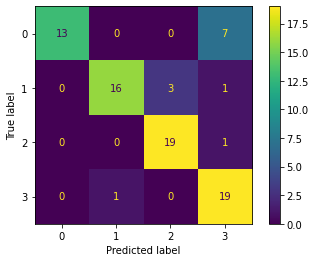

In [121]:
y_predict = model.predict(rescaled_X_test)
ConfusionMatrixDisplay.from_predictions(encoded_y_test, y_predict)

In [122]:
print(classification_report(encoded_y_test, y_predict))

              precision    recall  f1-score   support

           0       1.00      0.65      0.79        20
           1       0.94      0.80      0.86        20
           2       0.86      0.95      0.90        20
           3       0.68      0.95      0.79        20

    accuracy                           0.84        80
   macro avg       0.87      0.84      0.84        80
weighted avg       0.87      0.84      0.84        80



## Save Model

In [123]:
filename = 'rfc_model.sav'
joblib.dump(model, f'/content/drive/MyDrive/banana-leaf/output/{filename}')

['/content/drive/MyDrive/banana-leaf/output/rfc_model.sav']

# Prediction

## Setup Environment

In [73]:
import joblib
import cv2
import numpy as np

In [124]:
# ubah ke output/rfc_model.sav
PATH_MODEL = '/content/drive/MyDrive/banana-leaf/output/rfc_model.sav'
FIXED_SIZE = (500, 500)
TEST_PATH = 'dataset/test'

In [126]:
loaded_model = joblib.load(PATH_MODEL)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [137]:
def preprocess(filename):
    label_name = filename.split('/')[-2] # ubah '/' jadi '\'
    image = cv2.imread(filename)
    image = cv2.resize(image, FIXED_SIZE)

    # TODO: tampilkan
    # jalankan fungsi preprocessing satu per satu
    bgr_image = rgb_bgr(image)
    hsv_image = bgr_hsv(bgr_image)
    segmented_img = img_segmentation(bgr_image,hsv_image)

    # jalankan fungsi feature descriptor
    fv_hu_moments = fd_hu_moments(segmented_img)
    fv_haralick = fd_haralick(segmented_img)
    fv_histogram = fd_histogram(segmented_img)
        
    # gabungin
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
    
    return global_feature.reshape(1,-1), label_name


In [140]:
PATH = '/content/dataset/test/cordana/1615455263914.jpg'
image_feature, label_name = preprocess(PATH)

predicted_label = loaded_model.predict(image_feature)

In [142]:
if predicted_label == 0:
    predicted_label_name = 'cordana'
elif predicted_label == 1:
    predicted_label_name = 'healthy'
elif predicted_label == 2:
    predicted_label_name = 'pestaliopsis'
else:
    predicted_label_name = 'sigatoka'

In [144]:
print(f'Label asli: {label_name}')
print(f'Label diprediksi: {predicted_label_name}')

Label asli: cordana
Label diprediksi: cordana


di py nya nanti tampilkan gambar foto yang di load, label aslinya, dan label prediksi nya

In [ ]:
image = cv2.imread(PATH)
# cv2.putText(image,
#             f'Label asli: {label_name})
cv2.imshow('image', image)